In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm

from utilities import import_networks

# from networkx.algorithms.community.centrality import girvan_newman
# from networkx.algorithms.community import lukes_partitioning

import matplotlib.pyplot as plt
import numpy as np

import infomap

In [2]:
networks = import_networks()

print("\n".join([str(x) for x in networks]))

Graph with 1001 nodes and 75862 edges
Graph with 999 nodes and 75415 edges
Graph with 1025 nodes and 80306 edges
Graph with 1018 nodes and 80077 edges


# Infomap
---

In [4]:
%%time
infomap_comms = {}
for g in networks:
    im = infomap.Infomap("--two-level",num_trials=10,silent=False)
    graph = im.add_networkx_graph(g)
    im.run()
    comms = im.get_modules()
    infomap_comms[g.graph["year"]] = [[graph[i] for i,c in comms.items() if c==n] for n in set(comms.values())]

  Infomap v1.7.2 starts at 2021-11-03 22:19:12
  -> Input network: 
  -> No file output!
  -> Configuration: two-level
                    num-trials = 10
  OpenMP 201511 detected with 8 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 1001 nodes and 75862 links...
Calculating one-level codelength... done!
 -> One-level codelength: 9.37463502
Calculating entropy rate... done!
  -> Entropy rate: 4.885594456

Trial 1/10 starting at 2021-11-03 22:19:12
Two-level compression: 14% 0.42% 
Partitioned to codelength 0.973301435 + 7.07292095 + 0 = 8.046222387 in 19 (18 non-trivial) modules.

=> Trial 1/10 finished in 0.088927s with codelength 8.04622239

Trial 2/10 starting at 2021-11-03 22:19:12
Two-level compression: 14% 0.39% 
Partitioned to codelength 1.09980918 + 6.94979606 + 0 = 8.0496

In [5]:
modularity_scores = [nx_comm.modularity(g,comm,weight="weight") for g,comm in zip(networks,infomap_comms.values())]
print(modularity_scores)

[0.5884019556081407, 0.5726227302137232, 0.5782569631556358, 0.5743501282946955]


In [6]:
# Find matching communities
def enumerate_simmilarity(d1,d2):
    scores = []
    simmilarity = lambda d,d1: len(d1.keys() & d.keys()) * sum([d1[c]*d[c]/(1+abs(d1[c]-d[c])) for c in (d1.keys() & d.keys())])
    for d in d1:
        scores.append([simmilarity(d,dd) for dd in d2])
        
    scores = np.array(scores,dtype=float)
    best = np.full(len(d1),-1)
        
    for i in range(len(d1)):
        index = np.unravel_index(scores.argmax(),scores.shape)
        best[index[0]] = index[1]
        scores[index[0]] = -1
        scores[:,index[1]] = -1
     
    return list(zip(best,d1))

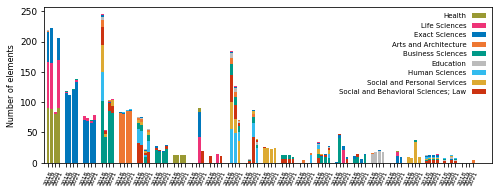

In [7]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(17.8*cm,7*cm))

areas_in_comm = []
for n, G in enumerate(networks):
    comm = [[G.nodes[y]["area"] for y in x] for x in infomap_comms[G.graph["year"]]]
    areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])
    
max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
max_comms = max(areas_in_comm, key = len)
max_comms_enum = list(enumerate(max_comms))

for i in range(0,4):
    if i == max_idx: 
        areas_in_comm[i] = max_comms_enum
        continue
    areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

# ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")